In [1]:
# Reload all modules every time before executing the Python code typed
%load_ext autoreload
%autoreload 2

In [375]:
import re
import json
import glob
from urllib.parse import urljoin
import requests
from pathlib import Path
from tqdm import tqdm
from bs4 import BeautifulSoup
import roman
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import osmnx as ox

import cafeconmiel.data.parse_html as parse_html
import cafeconmiel.data.metadata as metadata

from dotenv import load_dotenv
load_dotenv()

True

In [3]:
proj_path = Path(os.environ['PROJ_DIR'])
data_dir = proj_path / 'data'
interim_data = data_dir / 'interim'
letters_path = data_dir / 'external' / 'Cartas-txt'
legal_docs_path = data_dir / 'external' / 'documentos arreglados CorpMA'

In [21]:
meta_fields = ['meta_id', 'format', 'corpus', 'unknown_id', 'date (place)', 'doc_type', 'abstract', 'author']
es_months = ['enero', 'febrero' ,'marzo', 'abril', 'mayo', 'junio', 'julio', 'agosto', 'septiembre', 'octubre', 'noviembre', 'diciembre']
es_month_name_to_number = {name: str(i+1).zfill(2) for i, name in enumerate(es_months)}
# add user agent to trick website into thinking we're accessing from a browser
headers = {
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.12; rv:55.0) Gecko/20100101 Firefox/55.0',
}

In [269]:
def read_doc(doc_id, dir_path):
    legal_doc_path = dir_path / f'{doc_id}p.txt'
    if legal_doc_path.exists():
        path = legal_doc_path
    else:
        path = next(dir_path.glob(f"*({doc_id}).txt"))
    with open(path, 'r') as f:
        txt = f.read()
    return txt

In [6]:
corpus_metadata = {
    'corpusmallorca':
        {
            'base_url': 'https://corpusmallorca.es',
            'remote_doc_list': 'buscar.php?&paleografica=on&critica=on&maxFiles=999999&nFilei=0&nFilef=1000&selDonde=0',
        },
    'corpuscodea':
        {
            'base_url': 'https://corpuscodea.es/corpus',
            'remote_doc_list': 'consultas.php',
            'local_doc_list': 'docs.html'
        },
    'corpuscharta':
        {
            'base_url': 'https://www.corpuscharta.es',
            'remote_doc_list': 'consultas.html',
            'local_doc_list': 'docs.html',
        },
}
doc_url_patt = "{corpus_base_url}/documento.php"

In [299]:
field_norm = {
    'IDENTIFICADOR': 'meta_id',
    'REGESTO': 'abstract',
    'DOCUMENTO': 'abstract',
    'PAÍS': 'country',
    'PROVINCIA': 'region',
    'POBLACIÓN': 'locality',
    'FECHA': 'year',
    'SIGLO': 'century',
    'TIPOLOGÍA': 'doc_type',
    'TIP. DOCUMENTAL': 'doc_type',
    'TIP. DIPLOMÁTICA': 'diplo_type', # TODO: ??
    'ARCHIVO (SIGN.)': 'archive',
    'PALABRAS': 'nr_words',
    'MUJER': 'woman',
    'LETRA': 'writing',
    'ÁMBITO': 'context',
    'CLAVE': 'keywords',
    'COPISTA (FÓRM.)': 'copyist',
}

In [369]:
corpus_name = 'corpuscharta'
# corpus_name = 'corpuscodea'
corpus_dict = corpus_metadata[corpus_name]
corpus_dir = interim_data / corpus_name
corpus_dir.mkdir(exist_ok=True, parents=True)
docs_url = doc_url_patt.format(corpus_base_url=corpus_dict['base_url'])

# Extract data from corpus

## Online 

In [243]:
if 'local_doc_list' in corpus_dict:
    doc_list_path = data_dir / 'external' / corpus_name / corpus_dict['local_doc_list']
    with open(doc_list_path, 'r') as f:
        doc_list_html = f.read()
else:
    doc_list_url = urljoin(corpus_dict['base_url'], corpus_dict['remote_doc_list'])
    doc_list_html = requests.get(doc_list_url, headers=headers).content
doc_list_soup = BeautifulSoup(doc_list_html, 'html.parser')

In [244]:
if corpus_name == 'corpusmallorca':
    doc_ids = []
    for link in doc_list_soup.find_all('a'):
        doc_ids.append(re.match("javascript:abrirDocumento\('(.*)'\)", link.get('href')).groups()[0])

    for doc_id in tqdm(doc_ids):
        response = requests.get(docs_url, headers=headers, params={'documento': doc_id, 'paleografica': 'on', 'critica': 'on'})
        soup = BeautifulSoup(response.content, 'html.parser')

        data = parse_html.extract_metadata(soup, meta_fields, es_month_name_to_number)
        
        raw_text_soups = soup.find_all(class_='textopaleo')
        data['raw_text'] = ''.join([str(s) for s in raw_text_soups])
        data['text'] = parse_html.extract_text(raw_text_soups)
        with open(corpus_dir / f'{doc_id}.json', 'w') as f:
            json.dump(data, f)
        print(f'{doc_id} done')

else:
    # field_heads = soup.find(id='Tabla_Inventario').thead.find_all('tr')[-1].find_all('th')
    field_heads = doc_list_soup.find(id='Tabla_Inventario_wrapper').find('thead').find_all('tr')[-1] # codea
    ordered_field_names = [field_norm[h.div.text] for h in field_heads]
    pbar = tqdm(doc_list_soup.find(id='Tabla_Inventario').tbody.find_all('tr'))
    for doc_meta in pbar:
        field_values = [f.text.strip() for f in doc_meta.find_all('td')]
        data = dict(zip(ordered_field_names, field_values))
        # roman.fromRoman(data['century'])
        doc_id = data['meta_id']
        pbar.set_description(doc_id)
        if doc_id in docs_to_retrieve: ###
            response = requests.get(docs_url, headers=headers, params={'documento': doc_id, 'paleografica': 'on', 'critica': 'on'})
            soup = BeautifulSoup(response.content, 'html.parser')
            raw_text_soups = soup.find_all(class_='textopaleo')
            data['raw_text'] = ''.join([str(s) for s in raw_text_soups])
            data['text'] = parse_html.extract_text(raw_text_soups)
            with open(corpus_dir / f'{doc_id}.json', 'w') as f:
                json.dump(data, f)

CODEA-2495: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [02:10<00:00, 19.12it/s]


In [255]:
response = requests.get(docs_url, headers=headers, params={'documento': 'CODEA-1774', 'paleografica': 'on', 'critica': 'on'})
soup = BeautifulSoup(response.content, 'html.parser')
raw_text_soups = soup.find_all(class_='textopaleo')
# data['raw_text'] = ''.join([str(s) for s in raw_text_soups])
text = parse_html.extract_text(raw_text_soups)

CODCAR-0184 duplicated in charta's inventory for some reason

## Offline

# Edit pre-processed data

In [327]:
for path in corpus_dir.glob('*.json'):
    with open(path, 'r') as f:
        data = json.load(f)
        data['year'] = data.pop('date', data.get('year'))
        data['doc_type'] = data.pop('doct_type', data.get('doc_type'))
    with open(path, 'w') as f:
        json.dump(data, f)

# Load pre-processed data

In [382]:
records = []
for path in corpus_dir.glob('*.json'):
    with open(path) as f:
        records.append(json.load(f))
auto_df = pd.DataFrame.from_records(records)
auto_df = auto_df.set_index('meta_id')
auto_df = metadata.normalize(auto_df)
auto_df.head()

,abstract,country,region,locality,century,archive,nr_words,copyist,raw_text,text,year,doc_type
meta_id,,,,,,,,,,,,
CORHEN-0029,Donación\n sub modo de Sancha Seménez a favor ...,España,Burgos,Riolacedo,XII,Archivo Histórico Nacional,417,s.cop.,"<td class=""textopaleo""><img class=""img-facsimi...",\n Quoniam inter cetera pietatis opera; maxim...,1199.0,cartas de compraventa y contratos
CODCAR-0480,El\n infante don Sancho ordena a los merinos d...,España,Valladolid,S.Pbl.,XIII,Archivo de la Catedral de Burgos,260,Roy Martínez,"<td class=""textopaleo""><img class=""img-facsimi...",\n De mj jnffante don Sancho ffijo mayor & he...,1282.0,textos legislativos
CODCAR-0648,Ante\n la reclamación del obispo de Burgos de ...,España,Burgos,Quintanadueñas,XIII,Archivo de la Catedral de Burgos,3898,Joán Ferrández,"<td class=""textopaleo""><img class=""img-facsimi...",\n Don Sancho por la gracia de dios Rey de Ca...,1294.0,textos legislativos
CODEA-0688,Carta de cambio de posesiones entre el convent...,España,La Rioja,Cañas,XIII,Archivo Histórico Nacional,163,s.cop.,"<td class=""textopaleo""><img class=""img-facsimi...",\n Conosçuda cosa ssea a quantos omnes esta c...,1292.0,cartas de compraventa y contratos
CORHEN-0106,Contrato\n de mañería por el que el concejo de...,España,Burgos,Tamayo,XII,Archivo Histórico Nacional,230,s.cop.,"<td class=""textopaleo""><img class=""img-facsimi...",\n JN nomine dominj nostri ihesu xpisti. Notu...,1194.0,cartas de compraventa y contratos


In [424]:
auto_df['my_nr_words'] = auto_df['text'].str.count(r'\b\w+\b')
auto_df['nr_words'] = auto_df['nr_words'].astype(int)
rel_mask = (auto_df['nr_words'] - auto_df['my_nr_words']) / auto_df['my_nr_words'] > 0.2
abs_mask = auto_df['nr_words'] > 20
docs_to_retrieve = auto_df.loc[rel_mask & abs_mask].index
docs_to_retrieve

KeyError: 'nr_words'

In [413]:
corpus_name = 'all'
list_df = []
for c in corpus_metadata.keys():
    corpus_dir = interim_data / c
    records = []
    for path in corpus_dir.glob('*.json'):
        with open(path) as f:
            records.append(json.load(f))
    auto_df = pd.DataFrame.from_records(records)
    auto_df = auto_df.set_index('meta_id')
    auto_df = metadata.normalize(auto_df)
    auto_df['corpus'] = c
    list_df.append(auto_df)
auto_df = pd.concat(list_df, axis=0, join='inner')

In [415]:
# remove duplicates between codea and charta
auto_df = auto_df.groupby('meta_id').first()

In [397]:
auto_df['doc_type'].value_counts().head(20)

textos legislativos                  1128
cartas de compraventa y contratos     922
actas y declaraciones                 606
cartas privadas                       486
notas y breves                        247
certificaciones                       185
otros                                 144
testamentos e inventarios             134
informes y relaciones                 104
s.tip.                                 25
estatutos                              12
cartas particulares                     4
actas de compraventa y contratos        4
cartas                                  3
xxx                                     2
recibí                                  2
actas y declaraciónes                   1
certificaciónes                         1
nombramientos                           1
otros.                                  1
Name: doc_type, dtype: int64

In [416]:
auto_df['is_private'] = auto_df['doc_type'].isin(['cartas privadas', 'cartas particulares'])

In [423]:
df['region'].value_counts().head(20)

Madrid            465
Burgos            388
Valladolid        305
Sevilla           217
Toledo            199
Islas Baleares    195
Guadalajara       147
Málaga            138
Palencia          107
León              103
Zaragoza           97
Navarra            94
Segovia            93
Salamanca          79
Ávila              76
Cuenca             64
Alicante           58
La Rioja           58
Zamora             57
Cantabria          56
Name: region, dtype: int64

# Compare manually and automatically cleaned texts

In [401]:
manual_docs = {}
for fpath in letters_path.iterdir():
    match = re.match(r'.*_Lit \((.+)\)', fpath.name)
    if match is not None:
        doc_id = match.groups()[0]     
    with open(fpath, 'r') as f:
        manual_docs[doc_id] = f.read()

In [407]:
manual_docs = {}
for fpath in legal_docs_path.iterdir():
    match = re.match(r'(.+)p.txt', fpath.name)
    if match is not None:
        doc_id = match.groups()[0]     
        with open(fpath, 'r', encoding='Windows-1252') as f:
            manual_docs[doc_id] = f.read()

In [ ]:
for doc_id, text_by_hand in manual_docs.items():
    path = interim_data / f'{doc_id}.json'
    if path.exists():
        with open(interim_data / f'{doc_id}.json', 'r') as f:
            text_auto = json.load(f)['text']
        print(f'** {doc_id} **')
        print(text_by_hand)
        print(text_auto)
        break

this is a mess, nothing corresponds

In [ ]:
real_id = 'AMPO01_01'
manual_id = 'AMPO01_03'
text_by_hand = manual_docs[manual_id]
with open(interim_data / f'{real_id}.json', 'r') as f:
    text_auto = json.load(f)['text']
print(f'** {doc_id} **')
print(text_by_hand)
print(text_auto)

did it with AMPO01_01, which corresponds partly to AMPO01_03 (last paragraph), and removing \n and spaces, I get exact match

# Get places locations

In [380]:
from collections import defaultdict
places = defaultdict(lambda: 0)
places_dict = {}
for doc_id in doc_ids:
    with open(interim_data / f'{doc_id}.json', 'r') as f:
        p = json.load(f)['place']
        places[p] += 1
        places_dict[doc_id] = p

In [390]:
tags = {'place': 'city'}
gdf = ox.geometries_from_place('Madrid, Madrid', tags)
gdf

/home/thomaslouf/.conda/envs/cafeconmiel/lib/python3.9/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


,,admin_level,capital,ele,is_capital,name,name:ab,name:am,name:an,name:ar,name:arc,...,source,source:date,source:ele,source:file,source:name,source:name:oc,source:population,wikidata,wikipedia,geometry
element_type,osmid,,,,,,,,,,,,,,,,,,,,,
node,21068295,2,yes,655,country,Madrid,Мaдрид,ማድሪድ,Madrit,مدريد,ܡܕܪܝܕ,...,Instituto Geográfico Nacional,2011-06,MDT5,http://centrodedescargas.cnig.es/CentroDescarg...,Nomenclátor Geográfico de Municipios y Entidad...,Lo Congrès,"BOE REAL DECRETO 1683/2007, de 14 de diciembre",Q2807,es:Madrid,POINT (-3.70358 40.41670)


# Quick viz

In [417]:
# df = auto_df[['doc_type', 'year', 'text'] + place_cols].copy()
df = auto_df.copy()

In [402]:
figs_path = proj_path / 'reports' / 'figures' / corpus_name
figs_path.mkdir(parents=True, exist_ok=True)

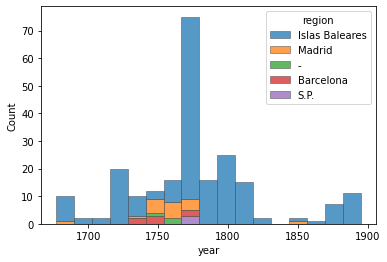

In [791]:
top_regions = df.groupby('region').size().sort_values().tail(5).index
ax = sns.histplot(
    df.loc[df['region'].isin(top_regions)].drop_duplicates(),
    x="year", hue="region",
    multiple="stack",
    edgecolor=".3",
    linewidth=.5,
)
ax.get_figure().savefig(figs_path / 'year_hist_by_region.pdf')

legal docs will most probably be useless, first for their content bu also region distribution: almost exclusively in baleares

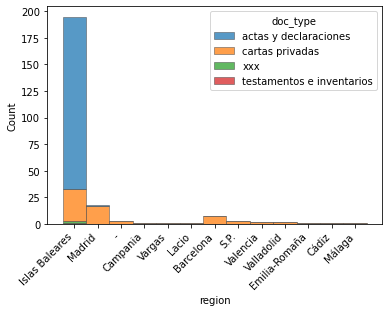

In [795]:
ax = sns.histplot(
    df.drop_duplicates(),
    x="region", hue="doc_type",
    multiple="stack",
    edgecolor=".3",
    linewidth=.5,
)
for item in ax.get_xticklabels():
    item.set_rotation(45)
    item.set_horizontalalignment('right')

ax.get_figure().savefig(figs_path / 'region_hist_by_doc_type.pdf', bbox_inches='tight')

however letters have very small year range

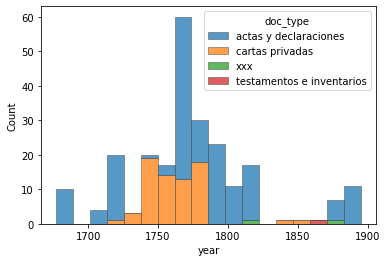

In [793]:
ax = sns.histplot(
    df.drop_duplicates(),
    x="year", hue="doc_type",
    multiple="stack",
    edgecolor=".3",
    linewidth=.5,
)
ax.get_figure().savefig(figs_path / 'year_hist_by_doc_type.pdf')

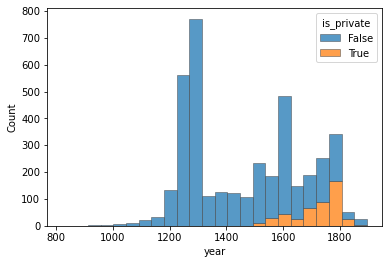

In [418]:
ax = sns.histplot(
    df.drop_duplicates(),
    x="year", hue="is_private",
    multiple="stack",
    edgecolor=".3",
    linewidth=.5,
)
ax.get_figure().savefig(figs_path / 'year_hist_private_or_not.pdf')

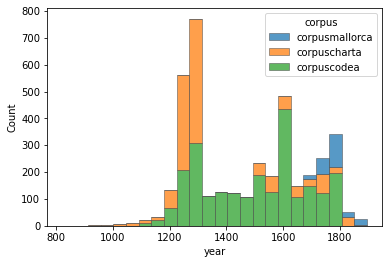

In [420]:
ax = sns.histplot(
    df,
    x="year", hue="corpus",
    multiple="stack",
    edgecolor=".3",
    linewidth=.5,
)
ax.get_figure().savefig(figs_path / 'year_hist_corpus.pdf')

# Word counts

## Pre-process

In [516]:
word_patt = re.compile(r'\b[^\W\d_]+?\b')
doc_type_mask = df['doc_type'] == 'cartas privadas'
years_mask = (df['year'] >= 1700) & (df['year'] < 1800)
doc_mask = doc_type_mask & years_mask
df['is_BA'] = df['region'] == 'Islas Baleares'

In [517]:
words_count_by_doc = df.loc[doc_mask]['text'].str.findall(word_patt).explode().rename('word').to_frame().groupby(['meta_id', 'word']).size().rename('count').to_frame()

## Global

In [528]:
global_counts = words_count_by_doc.groupby('word').sum()
global_counts['word_lower'] = global_counts.index.str.lower()
not_lower = global_counts.index != global_counts['word_lower']
global_counts.loc[not_lower, 'count_upper'] = (
    global_counts.loc[not_lower, 'count']
)
# Here we can round and cast to int, because if everything was previously
# done correctly (and this makes for a nice test), summing over all cells
# should give an integer, as counts from bbox places should be entirely
# spread among intersected cells.
global_counts = (
    global_counts.groupby('word_lower')
                        .sum()
                        .rename_axis('word_lower')
                        .round()
                        .astype(int)
                        .sort_values(by='count', ascending=False)
)
global_counts['upper_mask'] = global_counts['count_upper'] / global_counts['count'] < 0.4
# words_count_by_doc.to_frame().join(df['is_BA'], on='meta_id')

In [519]:
words_count_by_doc['word_lower'] = (
    words_count_by_doc.index.get_level_values(level='word').str.lower()
)
global_counts['nr_docs'] = words_count_by_doc.groupby(['meta_id', 'word_lower']).first().groupby('word_lower').size()

In [468]:
# nr docs
words_count_by_doc.index.levels[0].size

284

## Normed counts

In [520]:
words_count_by_doc.head()

count  word_lower
meta_id word                         
AMMC01  Alcudia         4     alcudia
        Bayle           2       bayle
        Binassalem      1  binassalem
        Cama            1        cama
        Camas           1       camas

In [529]:
normed_words_count_by_doc = words_count_by_doc.groupby(['meta_id', 'word_lower'])[['count']].sum().join(global_counts['upper_mask'].loc[global_counts['upper_mask']], how='inner')
# normed_words_count_by_doc = words_count_by_doc.loc[words_count_by_doc['upper_mask']].groupby(['meta_id', 'word_lower'])[['count']].sum()

### By doc

In [541]:
word_counts_mat = normed_words_count_by_doc['count'].unstack().fillna(0).astype(int).T

In [547]:
(word_counts_mat / word_counts_mat.sum(axis=0))

meta_id,AMMC01,AMMC02,AMMC03,AMMC04,AMMC05,AMMC06,AMMC07,AMMC09,CODEA-1502,CODEA-1759,...,SC06_66a,SC06_66b,SC06_69,SC06_7,SC06_70,SC06_73,SC06_74,SC06_76,SC06_77,SC06_91
word_lower,,,,,,,,,,,,,,,,,,,,,
a,0.006468,0.016129,0.01626,0.0,0.001215,0.0,0.0,0.000000,0.0,0.017544,...,0.0,0.0,0.028986,0.064103,0.008065,0.053571,0.0,0.028169,0.018182,0.028369
abandono,0.000000,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
abarios,0.000000,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
abastos,0.000000,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
abaxo,0.000000,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ôperacion,0.000000,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
ôquatromill,0.000000,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
ôtro,0.000000,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000


### By region

In [477]:
normed_words_count_by_reg = normed_words_count_by_doc.join(df['region'], on='meta_id').groupby(['word_lower', 'region'])[['count']].sum()

In [478]:
word_counts_mat = normed_words_count_by_reg['count'].unstack().fillna(0).astype(int)

In [479]:
bal_col = 'Islas Baleares'
reg_not_bal = [reg for reg in word_counts_mat.columns if reg != bal_col]
word_counts_mat['not_bal'] = word_counts_mat.loc[:, reg_not_bal].sum(axis=1)
# word_vec_out = word_counts_mat.loc[:, ('count', reg_not_bal)].values.sum(axis=1)
# word_vec_in = word_counts_mat.loc[:, ('count', bal_col)].values

In [480]:
word_counts_mat['total'] = global_counts['count']

In [481]:
word_counts_mat

region,Albacete,Alicante,Almería,Badajoz,Barcelona,Burgos,Campania,Cantabria,Castellón,Ceuta,...,Valencia,Valladolid,Vargas,Viena,Vizcaya,Zamora,Zaragoza,Álava,not_bal,total
word_lower,,,,,,,,,,,,,,,,,,,,,
a,25,52,8,6,19,5,3,1,7,0,...,17,9,4,3,6,0,33,0,584,659
ab,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
abad,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,1
abadesa,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,3
abajo,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ôrden,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,3,3
ôsadia,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
ôtro,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1


In [482]:
word_prop_mat = word_counts_mat / word_counts_mat.sum(axis=0)

In [483]:
word_prop_mat

region,Albacete,Alicante,Almería,Badajoz,Barcelona,Burgos,Campania,Cantabria,Castellón,Ceuta,...,Valencia,Valladolid,Vargas,Viena,Vizcaya,Zamora,Zaragoza,Álava,not_bal,total
word_lower,,,,,,,,,,,,,,,,,,,,,
a,0.026483,0.014424,0.018018,0.007833,0.018573,0.023697,0.007833,0.021739,0.016908,0.0,...,0.011565,0.019608,0.014035,0.017751,0.042254,0.0,0.026527,0.0,0.016311,0.014996
ab,0.000000,0.000277,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000028,0.000023
abad,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000804,0.0,0.000028,0.000023
abadesa,0.000000,0.000555,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000084,0.000068
abajo,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000028,0.000023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ôrden,0.000000,0.000000,0.000000,0.001305,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000680,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000084,0.000068
ôsadia,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000028,0.000023
ôtro,0.000000,0.000000,0.002252,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000028,0.000023


In [484]:
mask = word_counts_mat['total'] > 50
polar = ((word_prop_mat[bal_col] - word_prop_mat['not_bal']) / (word_prop_mat[bal_col] + word_prop_mat['not_bal'])).loc[mask]

In [485]:
polar.sort_values(ascending=False, key=np.abs).head(50)

word_lower
vuestras   -1.000000
señorias   -1.000000
señoria    -0.808807
don        -0.659074
vuestra    -0.612516
mui        -0.609097
pies       -0.609097
villa       0.563630
dela       -0.520326
tan        -0.501745
señor      -0.492632
nuestro    -0.480056
â           0.474722
à          -0.443733
ella       -0.421856
da          0.388267
puede      -0.386599
merced     -0.370433
ciudad     -0.368921
a          -0.363963
á           0.357887
ser         0.335914
nos        -0.316384
he         -0.306460
pues       -0.287055
las         0.271475
yo          0.267360
carta      -0.252183
v           0.238037
ya          0.228563
sra         0.228563
pero        0.216531
sus         0.215539
tiene      -0.211018
señora     -0.208841
se          0.200367
deseo       0.190302
señores    -0.188688
dn         -0.178727
por         0.175596
es         -0.166162
muy         0.164401
los         0.158114
no          0.155237
casa        0.148049
mas         0.145483
sin        -0.142348
de

-> 2 distribs, difference into PCA?

'â' in bold in texts for some reason

# Dumb clustering

In [435]:
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics
from sklearn.cluster import KMeans, MiniBatchKMeans, AgglomerativeClustering

In [565]:
# clustering_df = df.loc[doc_mask].copy()
clustering_df = df.loc[word_counts_mat.columns].copy()
labels = clustering_df['is_BA'].astype(int)
true_k = 2
n_components = 2

print("Extracting features from the training dataset using a sparse vectorizer")
vectorizer = TfidfVectorizer(
    max_df=0.5,
    token_pattern=r'\b[^\W\d_]+?\b',
    # max_features=opts.n_features,
    min_df=2,
    use_idf=False,
)
# X = vectorizer.fit_transform(clustering_df['text'].values)
X = (word_counts_mat / word_counts_mat.sum(axis=0)).values.T
print("n_samples: %d, n_features: %d" % X.shape)
print()

if n_components:
    print("Performing dimensionality reduction using LSA")
    # Vectorizer results are normalized, which makes KMeans behave as
    # spherical k-means for better results. Since LSA/SVD results are
    # not normalized, we have to redo the normalization.
    svd = TruncatedSVD(n_components)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)

    X = lsa.fit_transform(X)

    explained_variance = svd.explained_variance_ratio_.sum()
    print(
        "Explained variance of the SVD step: {}%".format(int(explained_variance * 100))
    )

# print()

# #############################################################################
# Do the actual clustering

# km = MiniBatchKMeans(
#     n_clusters=true_k,
#     init="k-means++",
#     n_init=1,
#     init_size=1000,
#     batch_size=1000,
#     verbose=opts.verbose,
# )
km = KMeans(
    n_clusters=true_k,
    init="k-means++",
    max_iter=100,
    n_init=1,
)

print("Clustering sparse data with %s" % km)
km.fit(X)
print()

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f" % metrics.adjusted_rand_score(labels, km.labels_))
print(
    "Silhouette Coefficient: %0.3f"
    % metrics.silhouette_score(X, km.labels_, sample_size=1000)
)

print("Top terms per cluster:")

if n_components:
    original_space_centroids = svd.inverse_transform(km.cluster_centers_)
else:
    original_space_centroids = km.cluster_centers_
dist = (original_space_centroids[0] - original_space_centroids[1])**2
order_centroids = original_space_centroids.argsort()[:, ::-1]
# terms = vectorizer.get_feature_names_out()
terms = word_counts_mat.index

for i in range(true_k):
    print("Cluster %d:" % i, end="")
    for ind in order_centroids[i, :20]:
        print(" %s" % terms[ind], end="")
    print()

Extracting features from the training dataset using a sparse vectorizer
n_samples: 279, n_features: 6781

Performing dimensionality reduction using LSA
Explained variance of the SVD step: 15%
Clustering sparse data with KMeans(max_iter=100, n_clusters=2, n_init=1)

Homogeneity: 0.035
Completeness: 0.017
V-measure: 0.023
Adjusted Rand-Index: -0.016
Silhouette Coefficient: 0.549
Top terms per cluster:
Cluster 0: que de y en la el a con por para se su me los lo mi enel no tubo del
Cluster 1: de y que la el en a con su por los para mi se del me lo las esta no


In [561]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(1-labels.values, km.labels_)
confusion

array([[  6,  23],
       [112, 138]])

In [562]:
precision = confusion[1,1] / (confusion[1,1] + confusion[0,1])
recall = confusion[1,1] / (confusion[1,1] + confusion[1,0])
accuracy = (confusion[1,1] + confusion[0,0]) / confusion.sum()
print(precision, recall, accuracy)

0.8571428571428571 0.552 0.5161290322580645


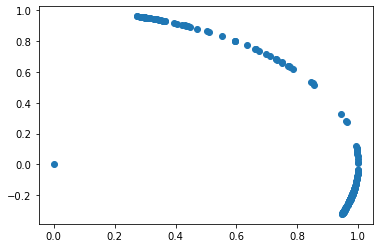

In [1010]:
plt.scatter(X[:, 0], X[:, 1])

In [977]:
km.cluster_centers_

array([[ 0.46710431,  0.83715092],
       [ 0.9753981 , -0.18788708]])

In [959]:
km.cluster_centers_.argsort()

array([[1, 3, 2, 4, 0],
       [3, 2, 4, 0, 1]])

In [446]:
original_space_centroids.shape

(2, 2706)

In [445]:
clustering_df['label'] = km.labels_

In [447]:
(1-df['label'] == df['is_BA']).sum()

KeyError: 'label'

In [440]:
df.loc[(1-df['label'] != df['is_BA'])]

KeyError: 'label'